<a href="https://colab.research.google.com/github/Jothish2283/Vanilla-Conv-autoencoders/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Vanilla AutoEncoder**

##**1.1. getting Data**

In [1]:
!pip -qq install torch_snippets torchinfo
import torch
import random
from torch import nn
import torchinfo
import torchvision
from torch_snippets import *

device= "cuda" if torch.cuda.is_available() else "cpu"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 962.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 40.3 MB/s eta 0:00

In [2]:
transformer= torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize([0.5], [0.5]), #converts data between [-1,1]
                                             torchvision.transforms.Lambda(lambda x: x.to(device))])

In [3]:
trn_ds=torchvision.datasets.MNIST("MNIST/", transform=transformer, train=True, download=True)
val_ds=torchvision.datasets.MNIST("MNIST/", transform=transformer, train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 295013845.68it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 13537739.59it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 77409184.89it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7260110.05it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [4]:
trn_ds[5][0].max(), trn_ds[5][0].min(), len(trn_ds[0][0])

(tensor(1., device='cuda:0'), tensor(-1., device='cuda:0'), 1)

In [5]:
trn_dl=torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)
val_dl=torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)

##**1.2. Building the Model**

In [6]:
class AutoEncoder(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    self.bottle_neck=latent_dim
    self.encoder=nn.Sequential(nn.Linear(28*28, 256),
                               nn.ReLU(),
                               nn.Linear(256, 128),
                               nn.ReLU(),
                               nn.Linear(128, 64),
                               nn.ReLU(),
                               nn.Linear(64, latent_dim))
    self.decoder=nn.Sequential(nn.Linear(latent_dim, 64),
                               nn.ReLU(),
                               nn.Linear(64, 128),
                               nn.ReLU(),
                               nn.Linear(128, 256),
                               nn.ReLU(),
                               nn.Linear(256, 28*28),
                               nn.Tanh()) #converts output in [-1,1]
  def forward(self, x):
    x=x.view(len(x), -1)
    x=self.encoder(x)
    x=self.decoder(x)
    x=x.view(len(x),1,28,28)
    return x

In [7]:
model=AutoEncoder(5)
torchinfo.summary(model, input_size=(32,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [32, 1, 28, 28]           --
├─Sequential: 1-1                        [32, 5]                   --
│    └─Linear: 2-1                       [32, 256]                 200,960
│    └─ReLU: 2-2                         [32, 256]                 --
│    └─Linear: 2-3                       [32, 128]                 32,896
│    └─ReLU: 2-4                         [32, 128]                 --
│    └─Linear: 2-5                       [32, 64]                  8,256
│    └─ReLU: 2-6                         [32, 64]                  --
│    └─Linear: 2-7                       [32, 5]                   325
├─Sequential: 1-2                        [32, 784]                 --
│    └─Linear: 2-8                       [32, 64]                  384
│    └─ReLU: 2-9                         [32, 64]                  --
│    └─Linear: 2-10                      [32, 128]                 8,32

##**1.3. Running the model**

In [8]:
def train_epoch(model, input, criterion, optimizer):
  model.to(device)
  model.train()
  output=model(input)
  loss=criterion(output, input)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss.item()

def val_epoch(model, input, criterion):
  model.eval()
  with torch.inference_mode():
    output=model(input)
    loss=criterion(output, input)
    return loss.item()

In [9]:
EPOCHS=5
criterion= torch.nn.MSELoss()
optimizer=torch.optim.Adam(params=model.parameters())

In [10]:
log= Report(EPOCHS)
for epoch in range(EPOCHS):
  n=len(trn_dl)
  for ix, (input, _) in enumerate(trn_dl):
    loss=train_epoch(model, input, criterion, optimizer)
    log.record(epoch+(ix+1)/n, train_loss=loss, end="\r")
  n=len(val_dl)
  for ix, (input, _) in enumerate(val_dl):
    loss=val_epoch(model, input, criterion)
    log.record(epoch+(ix+1)/n, val_loss=loss, end="\r")
  log.report_avgs(epoch+1)

EPOCH: 1.000  train_loss: 0.158  val_loss: 0.118  (33.86s - 135.44s remaining)
EPOCH: 2.000  train_loss: 0.112  val_loss: 0.106  (59.60s - 89.39s remaining)
EPOCH: 3.000  train_loss: 0.103  val_loss: 0.100  (84.89s - 56.60s remaining)
EPOCH: 4.000  train_loss: 0.099  val_loss: 0.097  (112.59s - 28.15s remaining)
EPOCH: 5.000  train_loss: 0.096  val_loss: 0.096  (138.12s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 412.87it/s]


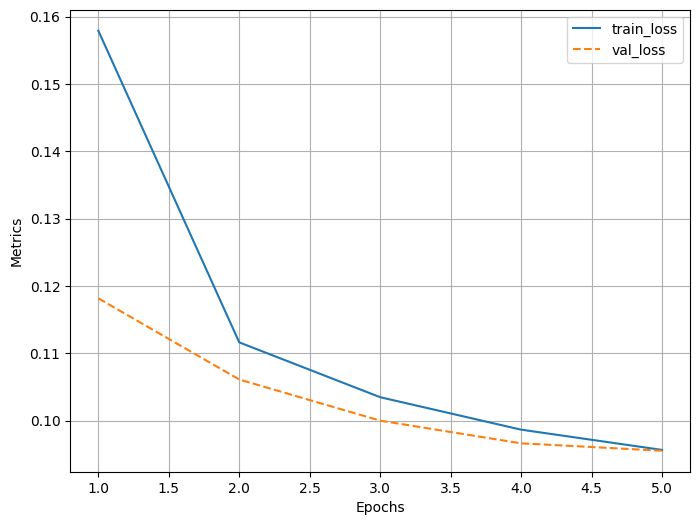

In [11]:
log.plot_epochs()

##**1.4. Testing on val data**

In [12]:
def testing(model, n_sample=1, conv=False):
  ims,_=next(iter(val_dl))
  for im in ims[:n_sample]:
    if conv: im=im.unsqueeze(0)
    output=model(im)
    subplots([im.squeeze().detach().to("cpu").numpy(), output.squeeze().detach().to("cpu").numpy()], nc=2, titles=["original", "predicted"])

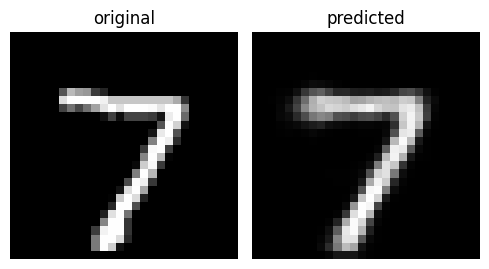

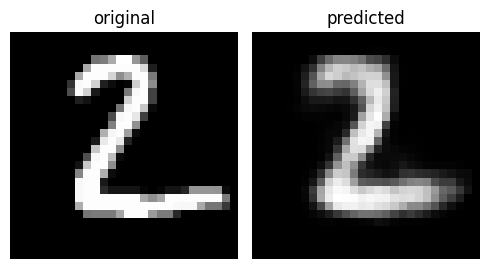

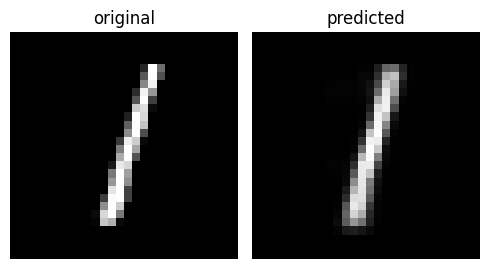

In [13]:
testing(model, n_sample=3)

##**1.5. Experimenting with latent dim_size**

In [14]:
dims=[2,3,5,10,50,64]

In [15]:
def train_auto_encoder(latent_dim):
  print("\n\nlatent_dim_size: ", latent_dim,"--------------")
  model=AutoEncoder(latent_dim)
  EPOCHS=5
  criterion= torch.nn.MSELoss()
  optimizer=torch.optim.Adam(params=model.parameters())

  log= Report(EPOCHS)
  for epoch in range(EPOCHS):
    n=len(trn_dl)
    for ix, (input, _) in enumerate(trn_dl):
      loss=train_epoch(model, input, criterion, optimizer)
      log.record(epoch+(ix+1)/n, train_loss=loss, end="\r")
    n=len(val_dl)
    for ix, (input, _) in enumerate(val_dl):
      loss=val_epoch(model, input, criterion)
      log.record(epoch+(ix+1)/n, val_loss=loss, end="\r")
    log.report_avgs(epoch+1)
  return model

models=[train_auto_encoder(dim) for dim in dims]

latent_dim_size:  2 --------------

EPOCH: 1.000  train_loss: 0.198  val_loss: 0.177  (31.92s - 127.67s remaining)
EPOCH: 2.000  train_loss: 0.169  val_loss: 0.163  (57.06s - 85.59s remaining)
EPOCH: 3.000  train_loss: 0.161  val_loss: 0.157  (82.15s - 54.76s remaining)
EPOCH: 4.000  train_loss: 0.157  val_loss: 0.157  (108.16s - 27.04s remaining)
EPOCH: 5.000  train_loss: 0.155  val_loss: 0.157  (134.38s - 0.00s remaining)


latent_dim_size:  3 --------------

EPOCH: 1.000  train_loss: 0.175  val_loss: 0.145  (25.13s - 100.50s remaining)
EPOCH: 2.000  train_loss: 0.140  val_loss: 0.134  (50.23s - 75.35s remaining)
EPOCH: 3.000  train_loss: 0.133  val_loss: 0.130  (75.21s - 50.14s remaining)
EPOCH: 4.000  train_loss: 0.129  val_loss: 0.127  (99.69s - 24.92s remaining)
EPOCH: 5.000  train_loss: 0.126  val_loss: 0.125  (124.15s - 0.00s remaining)


latent_dim_size:  5 --------------

EPOCH: 1.000  train_loss: 0.159  val_loss: 0.120  (24.79s - 99.16s remaining)
EPOCH: 2.000  train_loss: 0.113  val_loss: 0.107  (50.44s - 75.67s remaining)
EPOCH: 3.000  train_loss: 0.105  val_loss: 0.103  (75.05s - 50.04s remaining)
EPOCH: 4.000  train_loss: 0.100  val_loss: 0.100  (99.76s - 24.94s remaining)
EPOCH: 5.000  train_loss: 0.097  val_loss: 0.096  (124.23s - 0.00s remaining)


latent_dim_size:  10 --------------

EPOCH: 1.000  train_loss: 0.149  val_loss: 0.096  (24.69s - 98.74s remaining)
EPOCH: 2.000  train_loss: 0.089  val_loss: 0.082  (49.64s - 74.47s remaining)
EPOCH: 3.000  train_loss: 0.077  val_loss: 0.072  (74.26s - 49.51s remaining)
EPOCH: 4.000  train_loss: 0.070  val_loss: 0.068  (99.64s - 24.91s remaining)
EPOCH: 5.000  train_loss: 0.066  val_loss: 0.064  (124.23s - 0.00s remaining)


latent_dim_size:  50 --------------

EPOCH: 1.000  train_loss: 0.144  val_loss: 0.095  (24.74s - 98.95s remaining)
EPOCH: 2.000  train_loss: 0.085  val_loss: 0.074  (49.19s - 73.78s remaining)
EPOCH: 3.000  train_loss: 0.070  val_loss: 0.064  (73.67s - 49.11s remaining)
EPOCH: 4.000  train_loss: 0.060  val_loss: 0.056  (99.02s - 24.76s remaining)
EPOCH: 5.000  train_loss: 0.053  val_loss: 0.051  (124.93s - 0.00s remaining)


latent_dim_size:  64 --------------

EPOCH: 1.000  train_loss: 0.146  val_loss: 0.094  (25.64s - 102.55s remaining)
EPOCH: 2.000  train_loss: 0.082  val_loss: 0.073  (52.10s - 78.15s remaining)
EPOCH: 3.000  train_loss: 0.069  val_loss: 0.065  (76.53s - 51.02s remaining)
EPOCH: 4.000  train_loss: 0.061  val_loss: 0.057  (101.19s - 25.30s remaining)
EPOCH: 5.000  train_loss: 0.055  val_loss: 0.051  (125.79s - 0.00s remaining)


In [16]:
val_ds[3][0].shape

torch.Size([1, 28, 28])

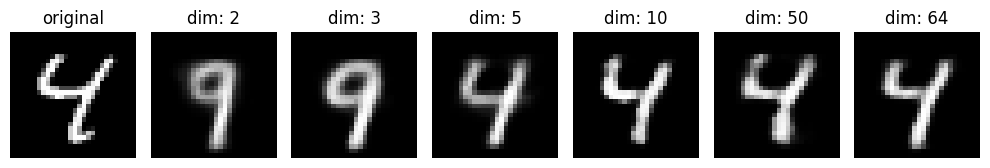

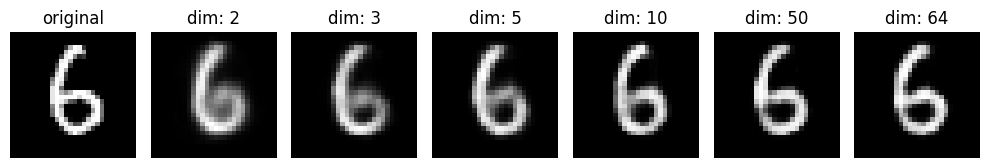

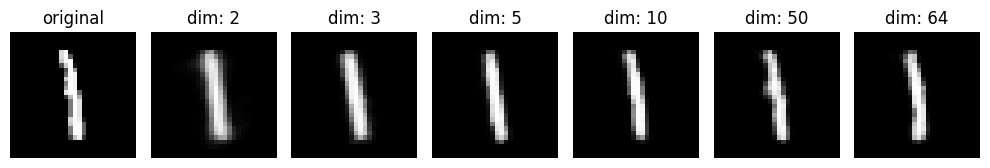

In [17]:
idx=random.choices(np.arange(32), k=3)
ims=[val_ds[id][0] for id in idx]
for im in ims:
  outputs=[]
  for model in models:
    outputs.append(model(im).squeeze().detach().to("cpu").numpy())
  outputs.insert(0, im.squeeze().detach().to("cpu").numpy())
  subplots(outputs, nc=7, titles=["original", f"dim: {dims[0]}", f"dim: {dims[1]}", f"dim: {dims[2]}", f"dim: {dims[3]}", f"dim: {dims[4]}", f"dim: {dims[5]}"], figsize=(10,4))

#**2. Convolutional AutoEncoder**

##**2.1. Building the Model**

In [18]:
class ConvAutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder=nn.Sequential(nn.Conv2d(1, 32, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(32),
                               nn.MaxPool2d(2),
                               nn.Conv2d(32, 64, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(64),
                               nn.MaxPool2d(2))
    self.decoder=nn.Sequential(nn.ConvTranspose2d(64, 32, 2, stride=2),
                               nn.ReLU(),
                               nn.BatchNorm2d(32),
                               nn.ConvTranspose2d(32, 1, 2, stride=2),
                               nn.Tanh())

  def forward(self, x):
    x=self.encoder(x)
    x=self.decoder(x)
    return x

In [19]:
model=ConvAutoEncoder()
torchinfo.summary(model, input_size=(32,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
ConvAutoEncoder                          [32, 1, 28, 28]           --
├─Sequential: 1-1                        [32, 64, 7, 7]            --
│    └─Conv2d: 2-1                       [32, 32, 28, 28]          320
│    └─ReLU: 2-2                         [32, 32, 28, 28]          --
│    └─BatchNorm2d: 2-3                  [32, 32, 28, 28]          64
│    └─MaxPool2d: 2-4                    [32, 32, 14, 14]          --
│    └─Conv2d: 2-5                       [32, 64, 14, 14]          18,496
│    └─ReLU: 2-6                         [32, 64, 14, 14]          --
│    └─BatchNorm2d: 2-7                  [32, 64, 14, 14]          128
│    └─MaxPool2d: 2-8                    [32, 64, 7, 7]            --
├─Sequential: 1-2                        [32, 1, 28, 28]           --
│    └─ConvTranspose2d: 2-9              [32, 32, 14, 14]          8,224
│    └─ReLU: 2-10                        [32, 32, 14, 14]          --
│    └

##**2.3. Running the model**

In [20]:
EPOCHS=25
criterion= torch.nn.MSELoss()
optimizer=torch.optim.Adam(params=model.parameters())

In [21]:
log= Report(EPOCHS)
for epoch in range(EPOCHS):
  n=len(trn_dl)
  for ix, (input, _) in enumerate(trn_dl):
    loss=train_epoch(model, input, criterion, optimizer)
    log.record(epoch+(ix+1)/n, train_loss=loss, end="\r")
  n=len(val_dl)
  for ix, (input, _) in enumerate(val_dl):
    loss=val_epoch(model, input, criterion)
    log.record(epoch+(ix+1)/n, val_loss=loss, end="\r")
  log.report_avgs(epoch+1)

EPOCH: 1.000  train_loss: 0.030  val_loss: 0.008  (27.28s - 654.71s remaining)
EPOCH: 2.000  train_loss: 0.008  val_loss: 0.006  (53.27s - 612.62s remaining)
EPOCH: 3.000  train_loss: 0.006  val_loss: 0.006  (80.00s - 586.70s remaining)
EPOCH: 4.000  train_loss: 0.005  val_loss: 0.005  (106.11s - 557.09s remaining)
EPOCH: 5.000  train_loss: 0.005  val_loss: 0.004  (132.38s - 529.50s remaining)
EPOCH: 6.000  train_loss: 0.004  val_loss: 0.004  (158.84s - 503.01s remaining)
EPOCH: 7.000  train_loss: 0.004  val_loss: 0.004  (185.10s - 475.97s remaining)
EPOCH: 8.000  train_loss: 0.004  val_loss: 0.004  (211.29s - 448.99s remaining)
EPOCH: 9.000  train_loss: 0.004  val_loss: 0.003  (237.30s - 421.86s remaining)
EPOCH: 10.000  train_loss: 0.004  val_loss: 0.003  (264.30s - 396.45s remaining)
EPOCH: 11.000  train_loss: 0.003  val_loss: 0.003  (290.24s - 369.40s remaining)
EPOCH: 12.000  train_loss: 0.003  val_loss: 0.003  (316.11s - 342.45s remaining)
EPOCH: 13.000  train_loss: 0.003  val_lo

100%|██████████| 126/126 [00:01<00:00, 97.41it/s] 


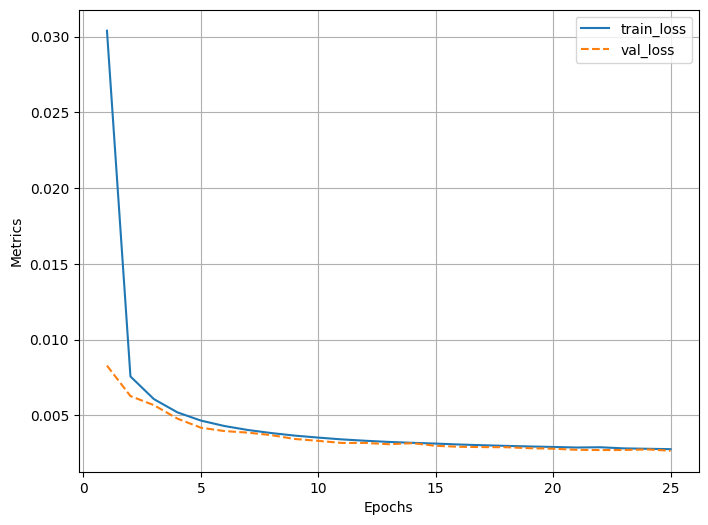

In [22]:
log.plot_epochs()

##**2.4. Testing on val data**

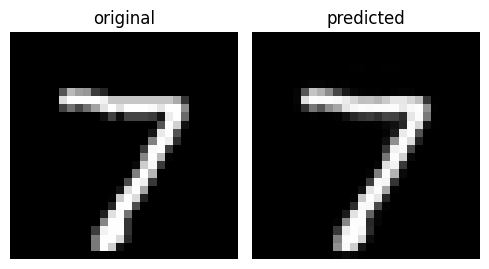

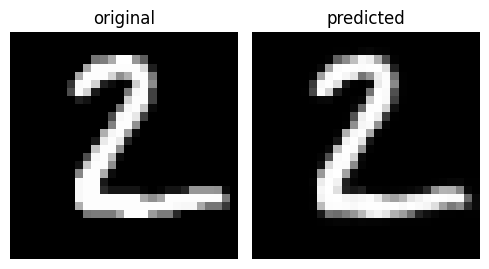

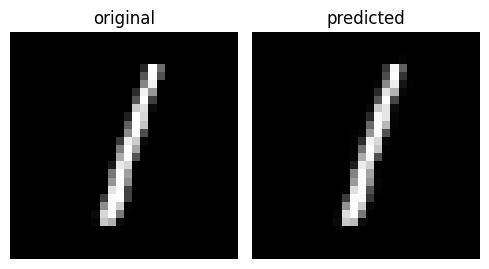

In [23]:
testing(model, n_sample=3, conv=True)

##**2.5. Comparing with vanilla encoder**

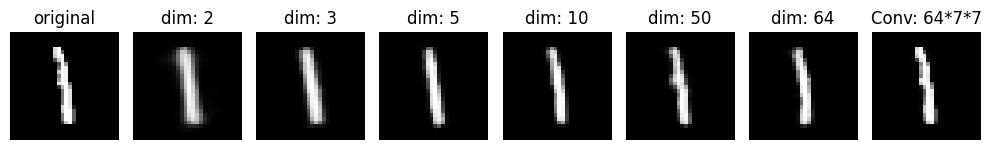

In [24]:
outputs.append(model(ims[-1].unsqueeze(0)).squeeze().detach().to("cpu").numpy())
subplots(outputs[-8:], nc=8, titles=["original", f"dim: {dims[0]}", f"dim: {dims[1]}", f"dim: {dims[2]}", f"dim: {dims[3]}", f"dim: {dims[4]}", f"dim: {dims[5]}", "Conv: 64*7*7"], figsize=(10,4))

#**3. Clustering using latent dim**

In [25]:
latent_v=[]
classes=[]

for im, clss in val_dl:
  latent_v.append(model.encoder(im).view(len(im), -1))
  classes.extend(clss)

In [26]:
latent_v[:2], classes[:2], latent_v[0].shape

([tensor([[ 0.7285,  0.6659,  0.6659,  ..., -0.0745, -0.0745, -0.0745],
          [ 0.7285,  0.8246,  0.1714,  ..., -0.0745, -0.0745, -0.0745],
          [ 0.7285,  0.6659,  0.6659,  ..., -0.0745, -0.0745, -0.0745],
          ...,
          [ 0.7285,  0.6659,  0.6925,  ..., -0.0745, -0.0745, -0.0745],
          [ 0.7285,  0.7154,  0.6615,  ..., -0.0745, -0.0745, -0.0745],
          [ 0.7285,  0.6659,  1.0502,  ...,  0.7347, -0.0745, -0.0745]],
         device='cuda:0', grad_fn=<ViewBackward0>),
  tensor([[ 0.7285,  0.9088,  1.6277,  ..., -0.0745, -0.0745, -0.0745],
          [ 0.7285,  0.7162,  1.0835,  ..., -0.0745, -0.0745, -0.0745],
          [ 0.7285,  0.7893,  0.6949,  ..., -0.0745, -0.0745, -0.0745],
          ...,
          [ 0.7285,  0.6659,  0.7175,  ..., -0.0745, -0.0745, -0.0745],
          [ 0.7285,  0.7399,  0.7215,  ...,  0.9241, -0.0745, -0.0745],
          [ 0.7285,  0.6659,  0.4746,  ..., -0.0745, -0.0745, -0.0745]],
         device='cuda:0', grad_fn=<ViewBackward0>)],

In [27]:
latent_v=torch.cat(latent_v).cpu().detach().numpy()
latent_v[:2]

array([[ 0.728527  ,  0.6659281 ,  0.6659281 , ..., -0.07448573,
        -0.07448573, -0.07448573],
       [ 0.728527  ,  0.8246278 ,  0.17141996, ..., -0.07448573,
        -0.07448573, -0.07448573]], dtype=float32)

In [28]:
latent_v[0].shape

(3136,)

In [29]:
from sklearn.manifold import TSNE
tsne=TSNE()

In [30]:
cluster=tsne.fit_transform(latent_v)

In [31]:
x,y=cluster[:,0], cluster[:,1]
x.shape, y.shape

((10000,), (10000,))

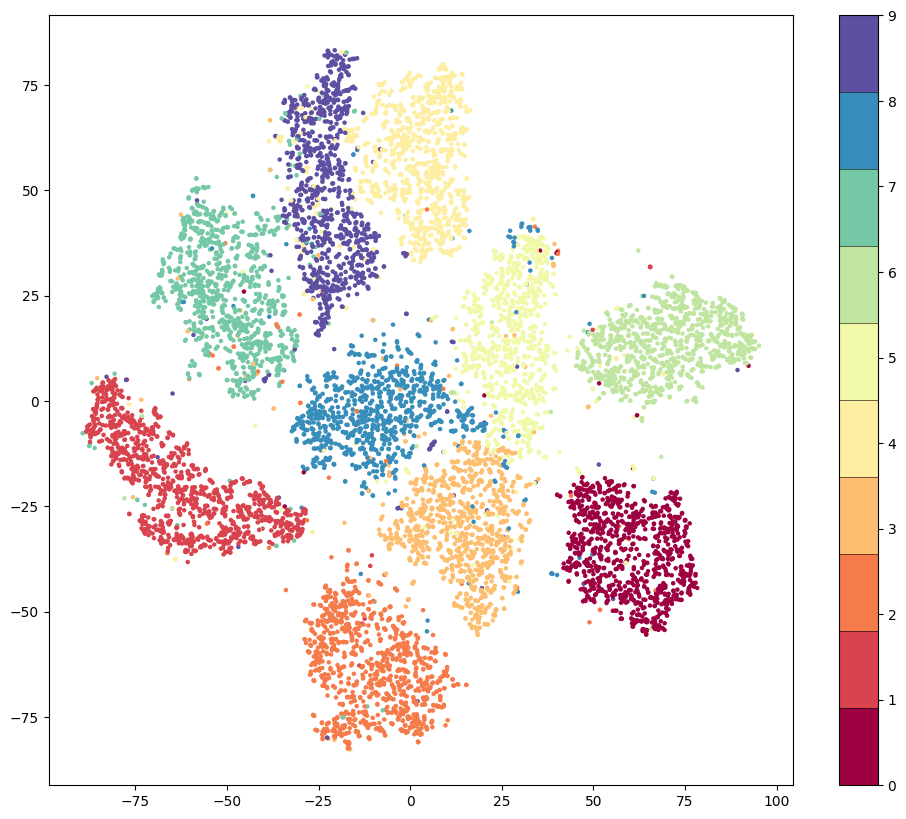

In [32]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,10))
plt.scatter(x, y, c=classes, cmap=plt.get_cmap("Spectral", 10), s=5);
plt.colorbar(drawedges=True);

#**4. Latent dim in between 2 clusters**

In [33]:
rand_v=[]
for column in latent_v.transpose(1,0):
  mean, std= column.mean(), column.std()
  rand_v.append(std*torch.randn(1,100)+mean)

rand_v=torch.cat(rand_v).transpose(1,0).to(device)

In [34]:
rand_v.shape

torch.Size([100, 3136])

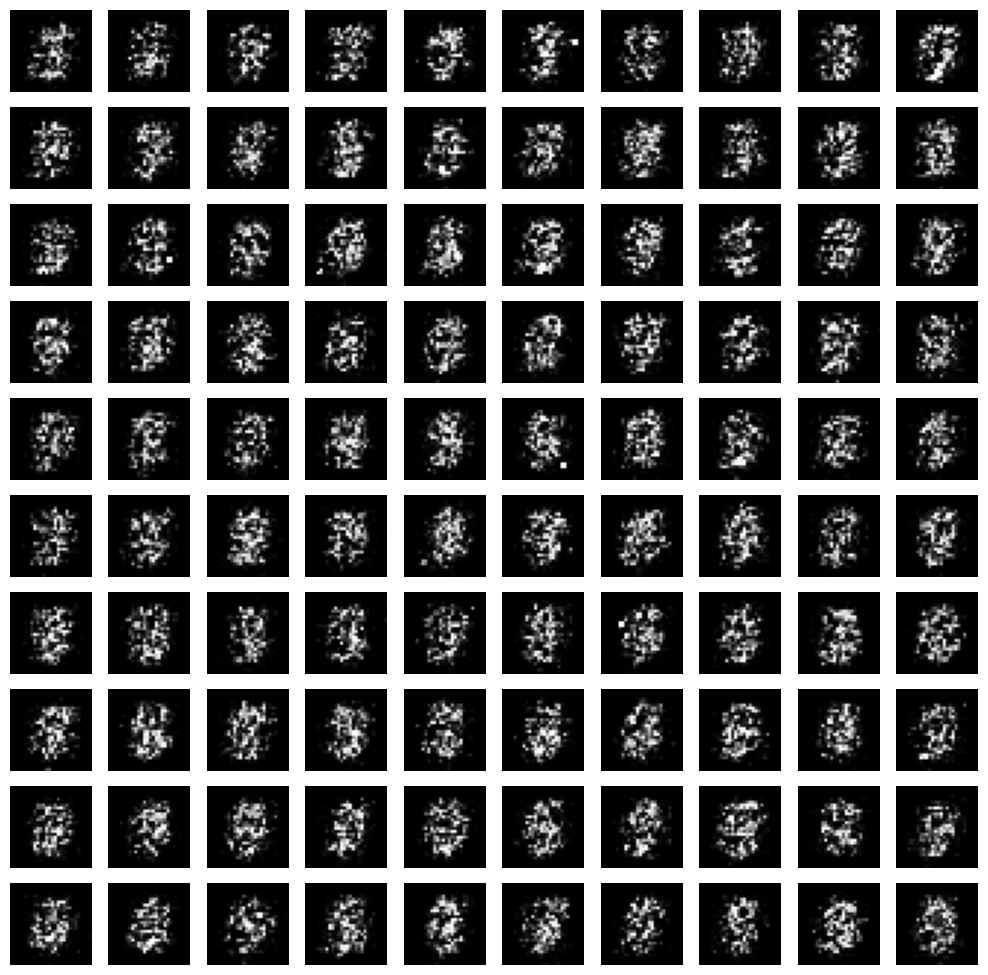

In [35]:
ims=model.decoder(rand_v.reshape(100,64,7,7))
ims=ims.detach().cpu().squeeze().numpy()
subplots(ims, nc=10, figsize=(10,10))